In [137]:
from fktools import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeMarrakesh
from qiskit.visualization import plot_histogram

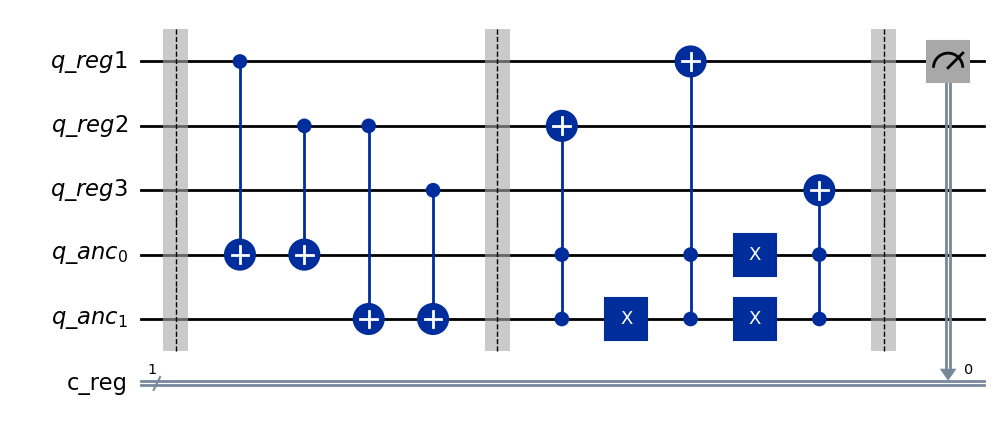

In [ ]:
q_reg1 = QuantumRegister(1, "q_reg1")
q_reg2 = QuantumRegister(1, "q_reg2")
q_reg3 = QuantumRegister(1, "q_reg3")
q_anc = QuantumRegister(2, "q_anc")
c_reg = ClassicalRegister(1, "c_reg")

qc =QuantumCircuit(q_reg1, q_reg2, q_reg3, q_anc, c_reg)

qc.cx(q_reg1[0], q_anc[0])
qc.cx(q_reg2[0], q_anc[0])
qc.cx(q_reg2[0], q_anc[1])
qc.cx(q_reg3[0], q_anc[1])

qc.barrier()

qc.ccx(q_anc[0], q_anc[1], q_reg2[0])

qc.x(q_anc[1])
qc.ccx(q_anc[0], q_anc[1], q_reg1[0])

qc.x(q_anc[0])
qc.x(q_anc[1])
qc.ccx(q_anc[0], q_anc[1], q_reg3[0])

qc.barrier()

qc.measure(q_reg1[0], c_reg[0])

qc.draw('mpl')

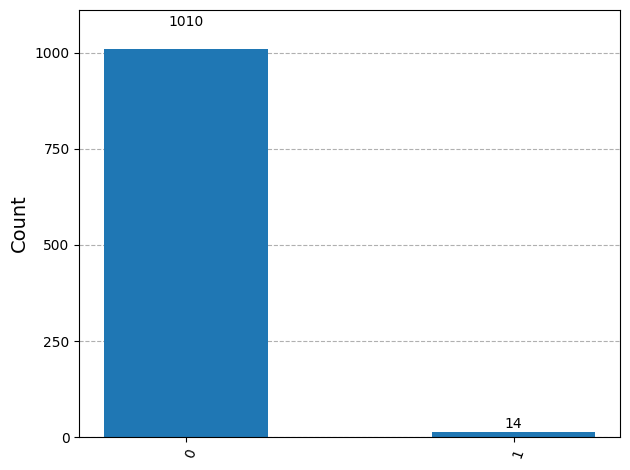

In [139]:
simulator = FakeMarrakesh()

tcirc = transpile(qc, simulator)

result = simulator.run(tcirc, shots=1024).result()
counts = result.get_counts()

plot_histogram(counts)

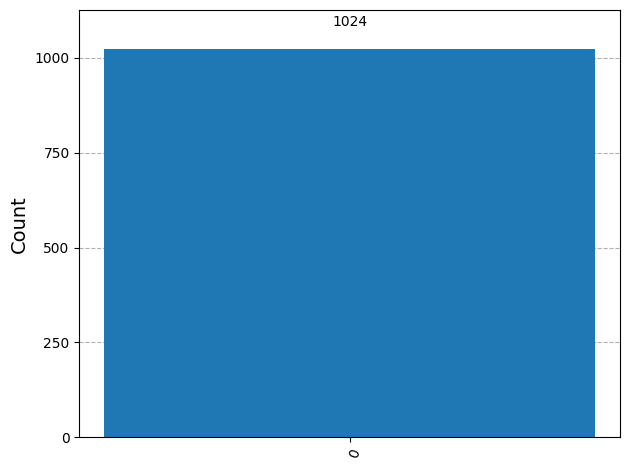

In [140]:
simulator = AerSimulator()

tcirc = transpile(qc, simulator)

result = simulator.run(tcirc, shots=1024).result()
counts = result.get_counts()

plot_histogram(counts)

# c_if

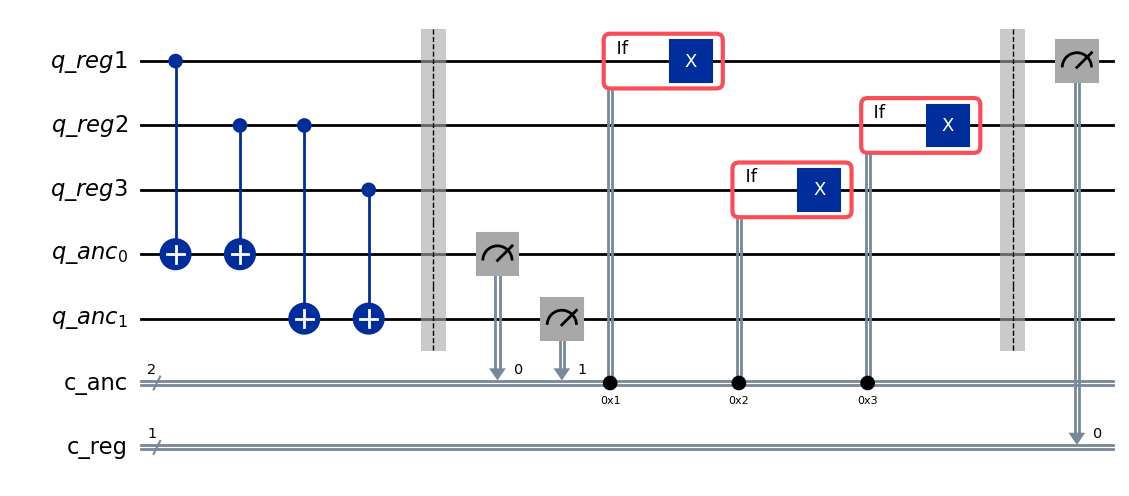

In [144]:
q_reg1 = QuantumRegister(1, "q_reg1")
q_reg2 = QuantumRegister(1, "q_reg2")
q_reg3 = QuantumRegister(1, "q_reg3")
q_anc = QuantumRegister(2, "q_anc")
c_anc = ClassicalRegister(2, "c_anc")
c_reg = ClassicalRegister(1, "c_reg")

qc =QuantumCircuit(q_reg1, q_reg2, q_reg3, q_anc, c_anc, c_reg)

qc.cx(q_reg1[0], q_anc[0])
qc.cx(q_reg2[0], q_anc[0])
qc.cx(q_reg2[0], q_anc[1])
qc.cx(q_reg3[0], q_anc[1])

qc.barrier()

qc.measure(q_anc, c_anc)

with qc.if_test((c_anc, 1)):
    qc.x(q_reg1[0])

with qc.if_test((c_anc, 2)):
    qc.x(q_reg3[0])

with qc.if_test((c_anc, 3)):
    qc.x(q_reg2[0])

# qc.x(q_reg3[0]).c_if(c_anc, 2)
# qc.x(q_reg2[0]).c_if(c_anc, 3)
# qc.ccx(q_anc[0], q_anc[1], q_reg2[0])

# qc.x(q_anc[1])
# qc.ccx(q_anc[0], q_anc[1], q_reg1[0])

# qc.x(q_anc[0])
# qc.x(q_anc[1])
# qc.ccx(q_anc[0], q_anc[1], q_reg3[0])

qc.barrier()

qc.measure(q_reg1[0], c_reg[0])

qc.draw('mpl')

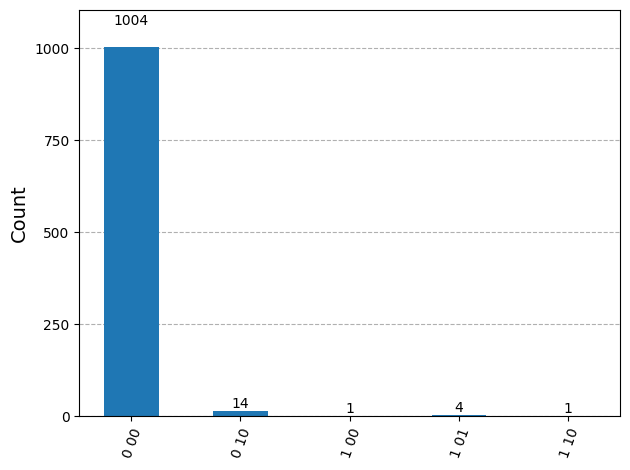

In [145]:
simulator = FakeMarrakesh()

tcirc = transpile(qc, simulator)

result = simulator.run(tcirc, shots=1024).result()
counts = result.get_counts()

plot_histogram(counts)